# Sistemas Inteligentes

## Curso académico 2024-2025

### Laboratorio 2: Búsqueda Metaheurística

#### Instructores

* Juan Carlos Alfaro Jiménez: JuanCarlos.Alfaro@uclm.es
* María Julia Flores Gallego: Julia.Flores@uclm.es
* Ismael García Varea: Ismael.Garcia@uclm.es
* Adrián Rodríguez López: Adrian.Rodriguez18@alu.uclm.es

## Estaciones de Servicio y Energía: Encontrando la Configuración Óptima

## 1. Introducción

¡Noticias emocionantes! El **Ministerio de Transporte y Movilidad Sostenible** ha quedado muy impresionado con las soluciones desarrolladas en nuestro primer trabajo, la Práctica 1. Están particularmente interesados en implementar estos algoritmos en la planificación de rutas de vehículos autónomos, con A* como el método MÁS efectivo para identificar el camino óptimo de manera eficiente. Para avanzar en este proyecto, el Ministerio tiene como objetivo establecer estratégicamente estaciones de servicio en áreas urbanas para apoyar su flota de vehículos autónomos. Estas estaciones funcionarán como centros de flota y proporcionarán servicios esenciales para los vehículos.

Para lograr esto, han solicitado **nuestra experiencia técnica para determinar la distribución óptima de estas estaciones** en los mapas de la ciudad. Sin embargo, no todas las intersecciones son elegibles como ubicación de una estación; el Ministerio ha preseleccionado intersecciones candidatas basándose en criterios específicos establecidos por sus equipos técnicos y administrativos. Su principal enfoque es la sostenibilidad y el acceso equitativo, con el objetivo de garantizar que todos los ciudadanos estén razonablemente cerca de una estación de servicio. Entre estos puntos seleccionados, solo se elegirá un número específico. Para facilitar nuestra tarea de determinar cuáles deben ser, han proporcionado datos sobre la cobertura poblacional de cada intersección candidata, lo que nos permite tener en cuenta tanto el acceso como la cobertura en nuestra estrategia de distribución.

El objetivo principal es garantizar un acceso eficiente a la máxima población posible, manteniendo una distribución equilibrada en toda la ciudad, una consideración vital para un sistema de transporte completamente autónomo.

### 1.1 Objetivos del Laboratorio

En esta práctica, aplicaremos técnicas de búsqueda metaheurística para resolver problemas de optimización combinatoria.

El primer objetivo es comprender la tarea y formularla desde la perspectiva de la búsqueda metaheurística. Implementaremos al menos dos algoritmos:

* **Búsqueda Aleatoria**, como un punto de partida básico que generará múltiples soluciones, evaluará cada una y devolverá la mejor.

* **Algoritmo Genético**, que permitirá configurar varios parámetros, como el tamaño de la población, la tasa de mutación y el número de generaciones, entre otros.


Además, para la evaluación no-continua se tendrá que implementar la Ascensión de Cplinas o Hill Cilimbing (obligatoriamente), y opcionalmente implementar el algoritmo **Iterated Local Search** (ILS), ambos explicados en el Tema 7.

A continuación, analizaremos y compararemos el rendimiento de estos algoritmos ejecutándolos en instancias de problemas de diferente complejidad.

Esperamos que esta práctica te ayude a profundizar en tu comprensión de las técnicas metaheurísticas y te anime a considerar cómo se pueden aplicar en problemas reales de optimización combinatoria.

**¡Buena suerte!**

## 2. Descripción del Problema

### 2.1 Problemas de Entrada

Cada escenario se proporcionará en un archivo en formato `json` que contiene la siguiente información, con el formato de un diccionario cuyas claves son:

* `address`: La dirección utilizada.
* `distance`: Radio máximo utilizado para definir intersecciones y segmentos alrededor de la dirección.
* `intersections`: Una lista de diccionarios con información sobre las intersecciones.
* `segments`: Una lista de diccionarios con información sobre los segmentos, que representan las calles entre dos intersecciones.
* `candidates`: Una lista de pares (identificador, población) que contiene las intersecciones candidatas. Notad que los identificadores en esta lista deben estar incluidos en la lista de intersecciones.
* `number_stations`: El número de estaciones de servicio que se deben ubicar, que no debe superar el número de candidatos.

Cada diccionario en `intersections` incluye tres claves:

* `identifier`: Identificador de la intersección
* `longitude`: Longitud de la intersección
* `latitude`: Latitud de la intersección

Cada diccionario en `segments` incluye cuatro claves:

* `origin`: Intersección de origen
* `destination`: Intersección de destino
* `distance`: Distancia entre las dos intersecciones
* `speed`: Velocidad máxima permitida entre las dos intersecciones

**IMPORTANTE**: `initial` y `final` ya no están incluidos en el archivo JSON, ya que no son necesarios. Durante la evaluación de una posible configuración, estos puntos iniciales y finales cambiarán varias veces. Esto puede requerir algunos ajustes en el código de la Práctica 1 para ejecutar A*. Estos cambios deben estar claramente indicados (tu código debe coincidir con el de la Práctica 1, excepto por estos cambios) y discutidos en la memoria de prácticas.

### 2.2. Ejemplo ilustrativo

Un posible ejemplo de este problema podría ser el que se muestra en la siguiente imagen, que representa una parte de la ciudad de Albacete:

![title](sample-problems-lab2/toy/example.png)

En este caso, el número de estaciones de servicio de vehículos que se deben ubicar es 4, entre las 15 intersecciones candidatas representadas con puntos azules (etiquetadas con la población cubierta). Una posible solución se representa con puntos verdes.

---

##### Nota:

* El archivo que contiene la imagen debe guardarse en la ruta indicada en el código de esta celda.

---

### 2.3 Definición formal del problema

Necesitamos elegir $s$ estaciones de entre $c$ intersecciones candidatas o elegibles, con $s<c$. Por lo tanto, nuestro objetivo es decidir en cuál de estas $c$ intersecciones candidatas debemos ubicar las $s$ estaciones de servicio de vehículos, de manera que se minimice el tiempo promedio de viaje que cada habitante tarda desde su hogar hasta la estación más cercana. Si denotamos por $S$ al vector de tamaño $s$ que contiene las intersecciones en las que se ubican las estaciones de vehículos y por $C$ al vector de intersecciones candidatas que contiene el par (id, pop) para cada intersección candidata, entonces formalmente, queremos resolver el siguiente problema de optimización:

$$
S^* = \arg\min_{S} \frac{1}{\sum_{i=0}^{c-1} C[i].pop} \cdot \min_{j=0,\dots,s-1} \left\{\sum_{i=0}^{c-1} \; C[i].pop \cdot time(C[i].id,S[j])\right\}
$$

donde:
- $C[i].pop$ representa la población (número de habitantes) cubierta por la intersección candidata $i$.
- $C[i].id$ es el identificador de la intersección candidata $i$.
- $time(A,B)$ representa el menor tiempo real para viajar desde la intersección $A$ hasta la intersección $B$.

Las siguientes consideraciones deben tenerse en cuenta respecto a la expresión anterior:
- Estamos tratando con un problema de minimización.
- La cardinalidad del espacio de búsqueda es:

$$
\binom{c}{s} = \frac{c!}{(c-s)!s!}
$$

por ejemplo, si tenemos 20 intersecciones elegibles y 4 estaciones de vehículos, el número de soluciones posibles es 210, no demasiadas; pero si tenemos 100 candidatos y 10 estaciones, entonces el número de soluciones posibles es $1.7\times10^{13}$ ($5.3\times 10^{20}$ con 20 estaciones).

## 3. Desarrollo de la práctica

Antes de implementar los algoritmos, primero debes considerar definir los elementos básicos en este tipo de problemas, a saber:

- Una representación conveniente para las soluciones (configuraciones, cromosomas, individuos, ...) del problema que se utilizarán en los algoritmos de optimización combinatoria. Piensa detenidamente en las distintas opciones y tendrás que discutirlas en el informe de la tarea.

- Implementar un mecanismo de evaluación para gestionar las evaluaciones realizadas por los algoritmos de optimización combinatoria. A continuación, se detallará cómo debe realizarse la evaluación.

- Notas importantes:
    - En el caso de que A* no devuelva ninguna solución (coste = inf), reemplazad este valor por un número muy alto en comparación con el tiempo máximo en nuestro problema. Reflexiona sobre la necesidad de esto y discútelo en el informe.
    - Podéis aprovechar el mecanismo de evaluación para guardar algunos cálculos, recopilar estadísticas e imprimir los resultados.
    - Tened en cuenta que esta tarea requiere que ya hayas resuelto la Práctica 1, y necesitarás reutilizar el código implementado para resolver esta práctica.
   
Tendréis que resolver muchos problemas similares a los de la Práctica 1. Los mapas serán los mismos, pero los problemas necesitan incorporar nueva información, que es la lista de intersecciones candidatas y, para cada una de ellas, la población que cubren. El número de estaciones que se deben ubicar también se indica en el problema como `number_stations`.


### 3.1 Evaluación de una solución

Dada una instancia específica del problema a resolver, y asumiendo que $C$ denota su lista de intersecciones candidatas, el valor de cada posible solución $S$ debe calcularse como:

$$value(S) = \frac{1}{\sum_{i=0}^{c-1} C[i].pop} \cdot \min_{j=0,\dots,s-1} \left\{\sum_{i=0}^{c-1} \; C[i].pop \cdot time(C[i].id,S[j])\right\}$$

de acuerdo con la fórmula presentada en la sección 2.2.

## 4. Plan de trabajo

### 4.1. Tareas

* Transferid y adaptad vuestro código de la Práctica 1 para resolver búsquedas con A* que necesitaréis aquí:
    * Reutilizad la mayor parte del código necesario de vuestra Práctica 1.
    * Describid qué se ha modificado, por qué y cómo.

* Procesad los nuevos archivos JSON y guardad el problema de acuerdo con lo siguiente:
    * Además de las clases de búsqueda (Problem_2, State, Action, ...), deberéis trabajar con las intersecciones candidatas.
    * Construid un mecanismo capaz de almacenar y recuperar las intersecciones candidatas y la población asociada a cada una.

* Representación de una posible configuración:
    * Entre las vistas en el Tema 6, encontrad la representación más adecuada para este problema y adaptadla, teniendo en cuenta que cada problema tiene valores distintos para el número total de intersecciones, intersecciones elegibles y el número solicitado de estaciones.
    * Conectadla a un método adecuado para evaluar cada una considerando las indicaciones mencionadas anteriormente en el punto 3.2.

* Implementación de algoritmos:
    * Implementad, al menos, los dos algoritmos requeridos (Búsqueda Aleatoria y un Algoritmo Genético — GA). Tened en cuenta que para la evaluación no continua, también deberéis agregar Hill Climbing y, opcionalmente, ILS.
    * En el GA, aseguraos de haber implementado la generación de una población junto con los elementos principales dentro del bucle principal: selección, cruce, mutación y combinación de generaciones.

* Experimentación y análisis:
    * Los parámetros que se puedan ajustar deben ser explorados adecuadamente, también en relación con los problemas dados (dimensionalidad, complejidad, etc.).
    * También deberéis estudiar el rendimiento resultante en términos de desempeño, convergencia, número de generaciones, etc.
    * Comparad la Búsqueda Aleatoria y el Algoritmo Genético, asegurándoos de obtener resultados consistentes.

* Informe:
    * Redactad un informe detallando el proceso seguido, las estrategias implementadas y los resultados obtenidos, junto con gráficos y comparaciones visuales.


### 4.2. Evaluación de la práctica

En la modalidad de **evaluación continua**, la evaluación de la práctica se realizará a través de un examen individual en el que se tendrá en cuenta lo siguiente:

* Definición e implementación correcta de la representación de la configuración y de la función de evaluación: 25%
* Implementación correcta del algoritmo genético: 50%, que cubre
    * El bucle general para las generaciones es correcto: 10%
    * Los distintos operadores están correctamente diseñados y codificados: 40%
* Eficiencia y optimización: 15%
* Experimentación realizada y análisis de resultados: 10%

Es necesario que la Práctica 1 esté correctamente integrada y que la Búsqueda Aleatoria funcione de manera consistente para que todos los estudiantes puedan utilizarla como un punto de partida base adecuado.

Todo esto se ponderará según el nivel de conocimiento que el estudiante demuestre sobre la práctica en caso de que el examen sea una entrevista personal.

En la modalidad de **evaluación no continua**, la evaluación se modificará como se indica a continuación:

* Definición e implementación correcta de la representación de la configuración y de la función de evaluación: 15%
* Implementación correcta del algoritmo genético: 40%, que cubre
    * El bucle general para las generaciones es correcto: 7%
    * Los distintos operadores están correctamente diseñados y codificados: 33%
* Implementación correcta del algoritmo de Hill Climbing (obligatorio): 15%
* Implementación correcta del algoritmo ILS (opcional): 5%
* Eficiencia y optimización: 15%
* Experimentación realizada y análisis de resultados: 10%


### 4.3. Fechas importantes

* Fecha límite para entregar el código: **13 de diciembre de 2024**.
* Fecha límite para la entrega del informe: **Final del semestre**.


## 5. Implementación de la Práctica 2

Aquí vamos a implementar la solución que hemos propuesto, estructuras de datos, clases con sus métodos necesarios.

#### Imports


In [45]:
from abc import ABC, abstractmethod
from queue import PriorityQueue
from functools import lru_cache
from geopy.distance import geodesic
from queue import PriorityQueue
import json, math, time, random
from matplotlib import pyplot as plt

#### Clase `Accion`

Esta clase represta las acciones que tendrá que hacer el vehículo autónomo. Una acción esta definida por un `origen` un `destino` y un `coste` por acción.

Métodos obligatorios: 

- `__init__(self, origen, destino, coste)`: Constructor de la clase con los necesarios argumentos (origen,destino y coste). Siendo el coste el tiempo que se tarda en llegar desde una intersección a otra
- `__lt__(self, other)`: Método para comprobar si el identificador de la interseccion destino es menor a otra

In [46]:
class Accion:

    def __init__(self, origen, destino, coste):
        self.origen = origen
        self.destino = destino
        self.coste = coste #Este coste viene en tiempo   

    def __lt__(self, other):
        return self.destino < other.destino

#### Clase `Estado`

Esta clase es la representacion de un Estado en el espacio de búsquedas. Un Estado está determinado por la `intersección`,`latitud` y `longitud` en la que el vehículo autónomo se encuentra. 

Métodos obligatorios: 

- `__init__(self, interseccion, latitud, longitud)`: Constructor de la clase.
- `__lt__(self, other)`: Método para comprobar que una interseccion es menor a otra.
- `aplicarAccion(self, accion)`: Dada una `Accion` válida, devuelve un la intersección destino generada al aplicar la `Accion` al `Estado` actual. 

In [47]:
class Estado:

    def __init__(self, interseccion, latitud, longitud):
        self.interseccion = interseccion
        self.latitud = latitud
        self.longitud = longitud

    
    def __lt__(self, other):
        return self.interseccion < other.interseccion
    
    def aplicarAccion(self, accion):
        if self.interseccion == accion.origen:
            return accion.destino
        raise Exception("No se puede aplicar la acción")

#### Clase `Nodo`. 

Esta clase es la representacion de un Nodo. Un `Nodo` está definido por el `Estado` al que representa, su `Nodo` padre, el coste del `Nodo` y la `profundidad`.
Además la clase `Nodo` tiene otros atributos que están relacionados con las estadísticas, como la profundidad o el coste. 

Métodos obligatorios: 

- `__init__(self, estado, padre=None, coste = 0, profundidad = 0)`: Constructor de la clase.
- `getSolucion(self)`: Método utilizado para construir la lista solución (relacionado con las estadísticas)
- `__lt__(self, other)`: Método utilizado para comparar si el `Estado` que representa el `Nodo` tiene menor identificador que otro

In [48]:
class Nodo:
    def __init__(self, estado, padre=None, coste = 0, profundidad = 0, generado = 0):
        self.estado = estado
        self.padre = padre
        self.coste = coste
        self.profundidad = profundidad
        self.generado = generado
    def getSolucion(self):
        solucion = []
        nodo = self
        while nodo.padre is not None:
            solucion.insert(0, nodo.estado.interseccion)
            nodo = nodo.padre
        solucion.insert(0, nodo.estado.interseccion)
        return solucion
    
    def __lt__(self, other):
        return self.estado < other.estado

#### Clase `Problema` 

Esta clase es la representanción del problema. Lee de un JSON la instancia del problema que debe ser resuelto. Atributos:
- distancia: distancia del radio máximo utilizado para definir intersecciones y segmentos alrededor
- estaciones: número de estaciones de servicio que hay que ubicar
- veloMax: velocidad máxima del problema (m/s)
- intersecciones: diccionario con todas las intersecciones del problema 
- acciones: diccionario con todas las acciones posibles para una interseccion dada 
- candidatos: tupla de intersecciones candidatas. El primer atributo es el identificador de la intersección y el segundo la población que cubre esa intersección

Métodos obligatorios: 

- `__init__(self, ruta)`: Constructor de la clase, se le pasa la ruta de donde se encuentra el JSON.
- `ordenarAcciones(self):` Método empleado para ordenar el diccionario de acciones.
- `getAcciones(self, estado)`: Método utilizado para devolver acciones posibles para un `Estado`. Una particularidad de este método es que utilizamos   @lru_cache(maxsize=100000) para ahorrarnos tiempo de ejecución guardando en caché las acciones de un `Estado` ya calculado previamente.


In [49]:
class Problema:
    def __init__(self, ruta):
        #abrimos el archivo y lo guardamos
        with open(ruta, 'r') as archivo:
            self.datos_json = json.load(archivo)

        self.distancia = self.datos_json["distance"]
        self.estaciones = self.datos_json["number_stations"]
        self.veloMax = 0

        self.intersecciones = {}
        self.acciones = {}  # Diccionario de acciones
        self.candidatos = []

        for dato in self.datos_json["intersections"]:
            estado = Estado(dato["identifier"], dato["latitude"],
                            dato["longitude"])
            self.intersecciones[dato["identifier"]] = estado
            self.acciones[dato["identifier"]] = []  # Inicializar como lista vacía

        for dato in self.datos_json["segments"]:
            accion = Accion(dato["origin"], dato["destination"],
                            (dato["distance"] / (dato["speed"] * (10 / 36))))
            self.acciones[dato["origin"]].append(accion)  # Añadir acción a la lista
            if dato["speed"] > self.veloMax:
                self.veloMax = dato["speed"]

        for dato in self.datos_json["candidates"]:
            self.candidatos.append((dato[0], dato[1]))

        self.veloMax = self.veloMax * (10 / 36)
        self.ordenarAcciones()  # Ordenar las acciones al crear el objeto

    def ordenarAcciones(self):
        for key in self.acciones:
            self.acciones[key].sort(key=lambda accion: accion.destino)

    @lru_cache(maxsize=100000)
    def getAcciones(self, estado):
        return self.acciones[estado.interseccion]

#### Clase `Busqueda`

La clase `Busqueda` es una clase abstracta, la cual tiene los siguientes atributos:
- El atributo problema, que guardará el `Problema` a resolver.
- El atributo frontera, el cual almacena los `Nodos` que se encuentran en estado abierto, es decir que se han generado pero no visitado aún. La estructura de este atributo cambiará dependiendo del método de búsqueda.
- El atributo nodos cerrados, el cual tendrá una estructura de conjuntos. Almacena los `Nodos` que se han comprobado si son solución.

La clase `Busqueda` tiene métodos abstractos: 
- `insertarNodo(self, nodo, frontera)`: Método utilizado para insertar un nodo en la lista.
- `extraerNodo(self, frontera)`: Método utilizado para extraer un nodo de la frontera.
- `esVacio(self, frontera)`: Método utilizado para comprobar si la frontera está vacía, es necesario que este método sea abstracto ya que la la estructura de datos de la frontera será distinta en las estrategias de búsqueda no informada e informada. 

Métodos obligatorios: 
- ` __init__(self, problema)`: Constructor de la clase.
- `expandir(self, nodo)`: Método utilizado para expandir un `Nodo`.
- `busqueda(self,cacheGlobalCandidatosCaminos)`: Método utilizado para realizar una búsqueda de grafos. Además utiliza una caché global, empleada para reducir el tiempo de búsqueda en caso de que se intente calcular el coste de un nodo ya explorado anteriormente. En caso de que no tenga solución devolvemos un valor muy alto.

Método relacionado con las estadísticas:
- `formatoTiempo(self, tiempo_total)`: Método utilizado para formatear el tiempo (tanto el coste como el de ejecución) a un patrón común. 

In [50]:
class Busqueda(ABC):
    def __init__(self, problema):
        #Datos que necesitamos para el problems
        self.problema = problema
        self.nodos_cerrados = set()
        self.frontera = None

    #Metodos implementados en las clases especificas
    @abstractmethod
    def insertarNodo(self, nodo, frontera):
        pass
    @abstractmethod
    def extraerNodo(self, frontera):
        pass
    @abstractmethod
    def esVacio(self, frontera):
        pass
    
    #Metodos para las estadisticas
    def formatoTiempo(self, tiempo_total): #El tiempo total tiene que estar dado en segundos
        horas = int(tiempo_total // 3600)
        minutos = int((tiempo_total % 3600) // 60)
        segundos = int(tiempo_total % 60)
        milisegundos = int((tiempo_total - int(tiempo_total)) * 1000000)
        tiempo_formateado = f"{horas:01d}:{minutos:02d}:{segundos:02d}.{milisegundos:06d}"
        return tiempo_formateado

    #Metodos para la busqueda
    def expandir(self, nodo):
        acciones = self.problema.getAcciones(nodo.estado) 

        for accion in range(len(acciones)):
            destino = nodo.estado.aplicarAccion(acciones[accion])
            if destino not in self.nodos_cerrados:
                nuevo_nodo = Nodo(
                    self.problema.intersecciones[destino],
                    padre=nodo,
                    coste=nodo.coste + acciones[accion].coste,
                    profundidad=nodo.profundidad + 1,
                    generado=nodo.generado + 1
                )
                self.insertarNodo(nuevo_nodo, self.frontera)
    
    def busqueda(self,cacheGlobalCandidatosCaminos):
        e_inicial = Nodo(self.inicio)
        self.insertarNodo(e_inicial, self.frontera)

        while not self.esVacio(self.frontera):
            nodo = self.extraerNodo(self.frontera)
            if nodo.estado.interseccion not in self.nodos_cerrados: #Sabemos que el nodo no ha sido explorado

                if ((nodo.estado.interseccion, self.final.interseccion) in cacheGlobalCandidatosCaminos): #Sabemos que el nodo ya ha sido calculado, return el resultado
                    return cacheGlobalCandidatosCaminos[nodo.estado.interseccion, self.final.interseccion]
                
                if (nodo.estado.interseccion in self.problema.candidatos) and nodo.estado.interseccion != self.inicio: #Sabemos que el nodo es un candidato, guardamos su coste
                    cacheGlobalCandidatosCaminos[self.inicio, nodo.estado.interseccion] = nodo.coste

                if nodo.estado.interseccion == self.final.interseccion:
                    return nodo.coste
                
                self.nodos_cerrados.add(nodo.estado.interseccion)
                self.expandir(nodo)

        return 3600*5     

#### Clase `Heuristica`

Se usa para la búsqueda informada, hemos utilizado la distancia geodésica para calcular la Heurística de A*, ya que está esta relacionada con la distancia entre 2 puntos. 
Se utiliza el método abstracto `getHeuristica(self, estado)` para calcular h(n).

In [51]:
class Heuristica(ABC):
    def __init__(self, problema, final):
        self.problema = problema
        #Obtenemos la lat y lon del estado objetivo
        self.lat_objetivo = self.problema.intersecciones[final.interseccion].latitud
        self.lon_objetivo = self.problema.intersecciones[final.interseccion].longitud
    @abstractmethod
    def getHeuristica(self, estado):
        pass

class Heuristica_Geodesica(Heuristica):
    def __init__(self, problema, final):
        super().__init__(problema, final)


    def getHeuristica(self, estado):
        # Obtener la intersección actual del estado
        # Calcular la distancia entre el estado actual y el estado objetivo
        lat_actual = self.problema.intersecciones[estado.interseccion].latitud
        lon_actual = self.problema.intersecciones[estado.interseccion].longitud

        #Formula para el calculo de la distancia geodesica
        distancia = geodesic((lat_actual, lon_actual), (self.lat_objetivo, self.lon_objetivo)).meters

        return distancia

#### Clase `Busqueda_a_estrella`

Clase heredada de la clase `Busqueda` por lo tanto heredadará sus mismos atributos y métodos.

La diferencia entre los algoritmos de búsqueda informada es la manera en la que se calcula el coste de un `Nodo`. El coste para cada estrategia de busqueda informada se calcula de la siguiente manera, siendo f(n) el coste del Nodo, g(n) el coste necesario para llegar del `Nodo` inicial al `Nodo` actual, y h(n) la heurística.:
- A*: $f(n) = g(n) + h(n)$ 

La heurística en este problema se calcula con: la distancia del nodo actual hasta el nodo objetivo dividido la velocidad máxima del problema.

La estructura de la frontera será una PriorityQueue, ya que es una estructura que almacena los datos de manera ordenada automáticamente según el valor que nosotros le indiquemos, en nuestro caso la heurística.

Los métodos son heredados de la clase `Busqueda` y serán de la siguiente manera:
- `__init__(self, problema, inicial, final):` Necesitamos pasar como parámetros el nodo inicial y el final ya que en la clase problema han desaparecido dichos atributos.
- `insertarNodo(self, nodo, frontera):` Introduce en la frontera un `Nodo`, la frontera se ordena automáticamente según la heurística asociada al `Nodo`.
- `extraerNodo(self, frontera):` Extrae el primer `Nodo` de la frontera
- `esVacio(self, frontera):` Devuelve verdadero si la frontera está vacío, falso si no lo está.

In [52]:
class Busqueda_a_estrella(Busqueda):
    
    def __init__(self, problema, inicial, final):
        super().__init__(problema)
        self.frontera = PriorityQueue()
        self.heuristica = Heuristica_Geodesica(problema, final)
        self.inicio = inicial
        self.final = final

    def insertarNodo(self, nodo, frontera):
        final = self.heuristica.getHeuristica(nodo.estado) / self.problema.veloMax
        nodo.heuristica =  nodo.coste + final 
        frontera.put(((nodo.heuristica), nodo))

    def extraerNodo(self, frontera):
        return frontera.get()[1]

    def esVacio(self, frontera):
        return frontera.empty()

#### Clase `BusquedaAleatoria`

Está clase implementa un algoritmo metahurístico de Búsqueda Aleatoria. Tiene los siguientes atributos:
- El atributo problema: Tendrá el `Problema` que deberá resolver.
- El atributo TamanoPoblacion: El valor de este atributo será un entero y será pasado como parámetro, representará el tamaño de la población.
- El atributo poblacion: Será una lista con la población, inicializada como una lista vacía con el mismo tamaño el atributo anterior. Cada atributo de la poblacion será una tupla con el individuo y su fitness asociado.
- El atributo mejorIndividuoFitness: El cual contendrá el mejor fitness posible encontrado para un individuo
- El atributo cacheCoste: Este atributo contendrá el coste asociado entre 2 intersecciones candidatas si ya se ha calculado previamente. El objetivo es aumentar la eficiencia del código no repitiendo operaciones calculadas previamente.
 
Métodos obligatorios:
- `__init__(self,problema, tamanoPoblacion):` Constructor de la clase
- `buscar(self):`: Método empleado para realizar la búsqueda, devolverá la mejor solución encontrada
- `inicializacion(self):` Se encarga de escoger aleatoriamente tantos individuos como el tamaño de la población y guardarlos en la población. Además también guardará el mejor fitness encontrado
- `evaluaIndividuo(self, individuo):` Este método se encarga de evaluar el fitness asociado a un individuo. Como queremos minimizar buscamos que el fitness asociado a un individuo sea el menor posible. En este método llamamos al algoritmo A* para comprobar el coste para ir de una intersección a otra, con el objetivo de mejorar la eficiencia hemos implementado una cache relacionada con el coste asociado a 2 intersecciones y así sabemos que si ya hemos calculado dicho coste no tenemos que ejecutar A* otra vez.

In [53]:
class BusquedaAleatoria():
    def __init__(self,problema, tamanoPoblacion):
        self.problema = problema

        self.tamanoPoblacion = tamanoPoblacion

        self.poblacion = [None] * tamanoPoblacion
        self.mejorIndividuoFitness = math.inf
        self.cacheCoste = {}

    
    def buscar(self):
        # Primero inicializamos la población
        self.inicializacion()

        mejor_solucion = min(self.poblacion, key=lambda x: x[1])
        print(f"Mejor solucion: {mejor_solucion}")

    def inicializacion(self):
        for i in range(self.tamanoPoblacion):
            individuo = random.sample(list(self.problema.candidatos), self.problema.estaciones)
            self.poblacion[i] = [individuo, self.evaluaIndividuo(individuo)]
            if self.poblacion[i][1] < self.mejorIndividuoFitness:
                self.mejorIndividuoFitness = self.poblacion[i][1]
    
    def evaluaIndividuo(self, individuo):
        pobTotal = 0
        valor = 0
        for candidata in range(len(self.problema.candidatos)):
            minimo = math.inf
            pobCandi = self.problema.candidatos[candidata][1]
            pobTotal += pobCandi

            inicio = self.problema.intersecciones[self.problema.candidatos[candidata][0]]
            for seleccionada in range(len(individuo)):
                if (self.problema.candidatos[candidata][0], individuo[seleccionada][0]) in self.cacheCoste:
                    coste = self.cacheCoste[self.problema.candidatos[candidata][0], individuo[seleccionada][0]]
                    if coste < minimo and coste != 0: #si no pones la comprobacion, encontes no tiene sentido ya que simpre sera el minimo aquel que sea de uno a el mismo
                        minimo = coste
                else:
                    final = self.problema.intersecciones[individuo[seleccionada][0]]
                    coste =  Busqueda_a_estrella(self.problema, inicio, final).busqueda(self.cacheCoste)
                    self.cacheCoste[self.problema.candidatos[candidata][0], individuo[seleccionada][0]] = coste 
                    if coste < minimo and coste != 0:
                        minimo = coste
                    
                
            valor += minimo * pobCandi
        

        return valor / pobTotal

#### Clase `BusquedaGenetica`

Está clase implementa un algoritmo metahurístico de Búsqueda Genética. Tiene los siguientes atributos:
- El atributo problema: Tendrá el `Problema` que deberá resolver.
- El atributo TamanoPoblacion: El valor de este atributo será un entero y será pasado como parámetro, representará el tamaño de la población.
- El atributo generaciones: El valor de este atributo indicará el número de generaciones que se generarán en el algoritmo.
- El atributo tamanoTorneo: Indicará el tamaño del torneo.
- El atributo mascara: Será una mascara llena con 0 y 1 (generados aleatoriamente) con el mismo tamaño que número de estaciones.
- El atributo poblacion: Será una lista con la población, inicializada como una lista vacía con el mismo tamaño el atributo anterior. Cada atributo de la poblacion será una tupla con el individuo y su fitness asociado.
- El atributo mejorIndividuoFitness: El cual contendrá el mejor fitness posible encontrado para un individuo
- El atributo mejorIndividuo: Será una tupla en el que el primer elemento será un individuo, y el segundo elemento su fitness asociado. Aqui guardaremos el individuo con el mejor fitness.
- El atributo cacheCoste: Este atributo contendrá el coste asociado entre 2 intersecciones candidatas si ya se ha calculado previamente. El objetivo es aumentar la eficiencia del código no repitiendo operaciones calculadas previamente.

Métodos obligatorios: 
- `__init__(self, problema, tamanoPoblacion, generaciones, tamanoTorneo = 5, elitismo = 5):` Constructor de la clase, para variar el algoritmo podríamos "jugar" con el tamaño de la población y las generaciones. El tamaño del torneo y el elitismo están inicializados a 5 pero también podrían variar si se desea.
- `buscar(self):` Método que realiza la búsqueda genética, este método será el encargado de ejecutar el algoritmo y llamar al resto de métodos necesarios para la ejecución del mismo. Por defecto hemos utilizado selección por torneo y cruce por 1 punto, sin embargo el resto de métodos también estan implementados para llamarlos debería intercambiarse dentro del método buscar.
- `inicializacion(self):` Se encarga de generar una población inicial, crea tantos individuos como tamaño tenga la población y los almacena dentro de la población. Además también guarda el mejor fitness y el individuo con mejor fitness.
- `evaluaIndividuo(self, individuo):` Este método se encarga de evaluar el fitness asociado a un individuo. Como queremos minimizar buscamos que el fitness asociado a un individuo sea el menor posible. En este método llamamos al algoritmo A* para comprobar el coste para ir de una intersección a otra, con el objetivo de mejorar la eficiencia hemos implementado una cache relacionada con el coste asociado a 2 intersecciones y así sabemos que si ya hemos calculado dicho coste no tenemos que ejecutar A* otra vez.
- Métodos de seleccion:
    - `seleccionProporcionalFitness(self):` En este método los individuos tienen una probabilidad directamente proporcional al fitness de ser elegidos
    - `seleccionRango(self):` En este método intentamos atenuar la presión selectiva que tiene el método proporcional al fitness.
    - `seleccionTorneo(self):` Es el método que hemos elegido, ya que nos hemos dado cuenta que nos da resultados razonables teniendo en cuenta el coste algoritimo que tiene asociado comparado con los dos métodos anteriores. Escogemos tantos individuos como tamaño del torneo de manera aleatoria y seleccionamos el individuo con mejor fitness asociado.
- Métodos de cruce:
    - `cruceUnPunto(self, padre1, padre2):` En este método escogemos un punto, una posicion en la lista, y se copia la información de un padre hasta ese punto y la información del otro padre en el otro, y viceversa. Conseguimos generar dos hijos con los individuos inversos entre ambos.
    - `cruceDosPuntos(self, padre1, padre2):` Este método es prácticamente igual al anterior, con la diferencia que en vez de cruzar por un punto se cruza por dos. Los hijos intercalan los individuos de un padre y de otro por ambos puntos.
    - `cruceUniforme(self, padre1, padre2):` Este método utiliza la máscara que se declaró en el constructor, crea dos hijos, donde hay 0 coge material genético de un padre y donde hay 1 del otro. En el otro hijo justamente lo contrario.
- `mutacion(self, hijo):` Se encargará de introducir nuevo material genético, con una probabilidad baja de mutación.

In [54]:

class BusquedaGenetica():
    def __init__(self, problema, tamanoPoblacion, generaciones, tamanoTorneo = 5, elitismo = 5):
        self.problema = problema

        self.tamanoPoblacion = tamanoPoblacion
        self.generaciones = generaciones
        self.tamanoTorneo = tamanoTorneo
        self.mascara = [random.randint(0, 1) for _ in range(problema.estaciones)]

        self.poblacion = [None] * tamanoPoblacion
        self.mejorIndividuoFitness = math.inf
        self.mejorIndividuo = [[],math.inf]
        self.cacheCoste = {}

    def buscar(self):
        tiempoej = time.perf_counter()
        tiempoEvaluacion = 0
        tiempoSeleccion = 0
        tiempoCruce = 0
        tiempoMutacion = 0

        # Primero inicializamos la población
        mejores = []
        self.inicializacion()

        tiemposs = time.perf_counter()- tiempoej
        for i in range(self.generaciones):  # Iterar sobre las generaciones            
            #print(f"Generacion {i+1}")
            #Guardamos la mejor solucion de cada generacion, es decir de todos los individuos el fitness
            #print(self.mejorIndividuoFitness)
            mejores.append(self.mejorIndividuoFitness)
            #seleccion de los individuos que pasaran a formar parte de la siguiente generacion
            tiempo = time.perf_counter()
            padres = self.seleccionTorneo()
            tiempoSeleccion += time.perf_counter() - tiempo


            for individuo in range(len(padres)-1):
                padre1 = padres[individuo]
                padre2 = padres[individuo+1]
                
                tiempo = time.perf_counter()
                hijo = self.cruceUnPunto(padre1, padre2)        
                tiempoCruce += time.perf_counter() - tiempo

                tiempo = time.perf_counter()
                hijo = self.mutacion(hijo)
                tiempoMutacion += time.perf_counter() - tiempo

                tiempo = time.perf_counter()
                hijo[1] = self.evaluaIndividuo(hijo[0])
                tiempoEvaluacion += time.perf_counter() - tiempo

                if self.poblacion[individuo][1] == self.mejorIndividuoFitness and hijo[1] < self.mejorIndividuoFitness:
                    self.mejorIndividuoFitness = hijo[1]
                    self.mejorIndividuo = hijo
                    self.poblacion[individuo] = hijo
                else :
                    self.poblacion[individuo] = hijo


        def imprimir():# Obtener la mejor solución de la población final
            tiempo_ej = time.perf_counter() - tiempoej
            print("TOTAL: ")
            print(Busqueda.formatoTiempo(self, tiempo_ej))
            mejor_fitness = min(mejores, key=lambda x: x)
            print(f"Mejor solucion: ")
            for candidato in self.mejorIndividuo[0]:
                print(f"{candidato[0]}")
            print(f"Mejor fitness: {mejor_fitness}")
            #Regla de 3 para conocer los %, si tiempo_ej es 100% calcular cuanto es cada cosa
            print("Porcentajes: ")
            inicializacion = tiemposs * 100 / tiempo_ej
            print(f"Inicializacion: {inicializacion}%")
            seleccion = tiempoSeleccion * 100 / tiempo_ej
            print(f"Seleccion: {seleccion}%")
            cruce = tiempoCruce * 100 / tiempo_ej
            print(f"Cruce: {cruce}%")
            mutacion = tiempoMutacion * 100 / tiempo_ej
            print(f"Mutacion: {mutacion}%")
            evaluacion = tiempoEvaluacion * 100 / tiempo_ej
            print(f"Evaluacion: {evaluacion}%")

        imprimir()

        return mejores 
        
    
    def inicializacion(self):
        for i in range(self.tamanoPoblacion):
            individuo = random.sample(list(self.problema.candidatos), self.problema.estaciones)
            self.poblacion[i] = [individuo, self.evaluaIndividuo(individuo)]
            if self.poblacion[i][1] < self.mejorIndividuoFitness:
                self.mejorIndividuoFitness = self.poblacion[i][1]
                self.mejorIndividuo = self.poblacion[i]
    
    def evaluaIndividuo(self, individuo):
        pobTotal = 0
        valor = 0
        for candidata in range(len(self.problema.candidatos)):
            minimo = math.inf
            pobCandi = self.problema.candidatos[candidata][1]
            pobTotal += pobCandi

            inicio = self.problema.intersecciones[self.problema.candidatos[candidata][0]]
            for seleccionada in range(len(individuo)):
                if (self.problema.candidatos[candidata][0], individuo[seleccionada][0]) in self.cacheCoste:
                    coste = self.cacheCoste[self.problema.candidatos[candidata][0], individuo[seleccionada][0]]
                    if coste < minimo and coste != 0: #si no pones la comprobacion, encontes no tiene sentido ya que simpre sera el minimo aquel que sea de uno a el mismo
                        minimo = coste
                else:
                    final = self.problema.intersecciones[individuo[seleccionada][0]]
                    coste =  Busqueda_a_estrella(self.problema, inicio, final).busqueda(self.cacheCoste)
                    self.cacheCoste[self.problema.candidatos[candidata][0], individuo[seleccionada][0]] = coste 
                    if coste < minimo and coste != 0:
                        minimo = coste
                    
                
            valor += minimo * pobCandi
        
        return valor / pobTotal
    
    #Metodos de seleccion
    def seleccionProporcionalFitness(self):
        # Calcular la suma total de los fitness
        total_fitness = sum(1 / individuo[1] for individuo in self.poblacion)  # Inverso del fitness para minimizar

        # Calcular probabilidades acumuladas
        probabilidades_acumuladas = []
        acumulado = 0
        for individuo in self.poblacion:
            prob = (1 / individuo[1]) / total_fitness
            acumulado += prob
            probabilidades_acumuladas.append(acumulado)

        # Seleccionar nuevos padres según las probabilidades
        padres = []
        for _ in range(self.tamanoPoblacion):
            r = random.random()  # Número aleatorio entre 0 y 1
            for i, acumulada in enumerate(probabilidades_acumuladas):
                if r <= acumulada:
                    padres.append(self.poblacion[i])
                    break

        return padres

    def seleccionRango(self):
        # Ordenar la población por fitness (ascendente para minimizar)
        poblacion_ordenada = sorted(self.poblacion, key=lambda x: x[1])
        N = len(poblacion_ordenada)  # Tamaño de la población

        # Calcular probabilidades por rango
        probabilidades_acumuladas = []
        acumulado = 0
        for i in range(1, N + 1):  # i = 1 para el mejor, hasta i = N para el peor
            prob = 2 * (N - i + 1) / (N ** 2 + N)
            acumulado += prob
            probabilidades_acumuladas.append(acumulado)

        # Seleccionar nuevos padres según las probabilidades acumuladas
        padres = []
        for _ in range(self.tamanoPoblacion):
            r = random.random()  # Número aleatorio entre 0 y 1
            for i, acumulada in enumerate(probabilidades_acumuladas):
                if r <= acumulada:
                    padres.append(poblacion_ordenada[i])
                    break

        return padres

    def seleccionTorneo(self):
        resultado = [None] * self.tamanoPoblacion
        for i in range(self.tamanoPoblacion):
            gladiadores = random.sample(self.poblacion, self.tamanoTorneo)
            resultado[i] = min(gladiadores, key=lambda x: x[1])
        
        return resultado

    #Metodos para el cruce
    def cruceUnPunto(self, padre1, padre2):
        if padre1[1] < padre2[1]:
            primero = True
        else: 
            primero = False

        if random.random() < 0.8:
            puntoCruce = random.randint(1, self.problema.estaciones-1)
            if primero:
                hijo = [padre1[0][:puntoCruce]+ padre2[0][puntoCruce:], 0]
            else:
                hijo = [padre2[0][:puntoCruce]+ padre1[0][puntoCruce:], 0]
        else : #Si no ocurre la probabilidad de cruce, devolvemos el padre con mejor fitness
            if primero:
                hijo = padre1
            else:
                hijo = padre2
        
        return hijo
    
    def cruceDosPuntos(self, padre1, padre2):
        if padre1[1] < padre2[1]:
            primero = True
        else:
            primero = False

        if random.random() < 0.8:  # Probabilidad de realizar el cruce
            punto1 = random.randint(1, self.problema.estaciones - 2)  
            punto2 = random.randint(punto1 + 1, self.problema.estaciones - 1)  # Nos aseguramos que punto2 > punto1

            if primero:
                hijo = [padre1[0][:punto1] + padre2[0][punto1:punto2] + padre1[0][punto2:], 0]
            else:
                hijo = [padre2[0][:punto1] + padre1[0][punto1:punto2] + padre2[0][punto2:], 0]
        else:  # Si no ocurre el cruce, devolvemos el mejor padre
            hijo = padre1 if primero else padre2

        return hijo

    def cruceUniforme(self, padre1, padre2):
        # Crear un conjunto para rastrear los candidatos que ya estan en el hijo (porque si no hay candidatos repetidos)
        candidatosUsados = set()
        hijo = [None] * self.problema.estaciones

        # Aplicar la máscara para construir el hijo
        for i in range(len(self.mascara)):
            # Elegir el gen según la máscara
            candidato = padre1[0][i] if self.mascara[i] == 1 else padre2[0][i]
            
            # Verificar si el gen ya fue usado
            if candidato not in candidatosUsados:
                hijo[i] = candidato
                candidatosUsados.add(candidato)
            else: #Seleccionamos un candidato aleatorio que no haya sido usado
                hijo[i] = random.choice([g for g in self.problema.candidatos if g not in candidatosUsados])
                candidatosUsados.add(hijo[i])

        print(hijo)

        return [hijo, 0]


    def mutacion(self, hijo):
        if random.random() < 0.1:
            puntoMutacion = random.randint(0, self.problema.estaciones-1)
            hijo[0][puntoMutacion] = random.choice(list(set(self.problema.candidatos) - set(hijo[0])))

        return hijo

# Pruebas

TOTAL: 
0:00:12.414587
Mejor solucion: 
1565088794
344859492
1991970573
335893167
1574598070
1835353347
335607954
1529197036
1574598083
1538396680
1293940877
1538396676
1554807205
335607957
1255499536
335893167
1528181121
1554813465
1528181136
1527972839
335720312
1526105942
Mejor fitness: 30.26836024054793
Porcentajes: 
Inicializacion: 76.11409645674202%
Seleccion: 0.13970259225181175%
Cruce: 0.07501739564918528%
Mutacion: 0.06453537201900582%
Evaluacion: 23.57312149292802%


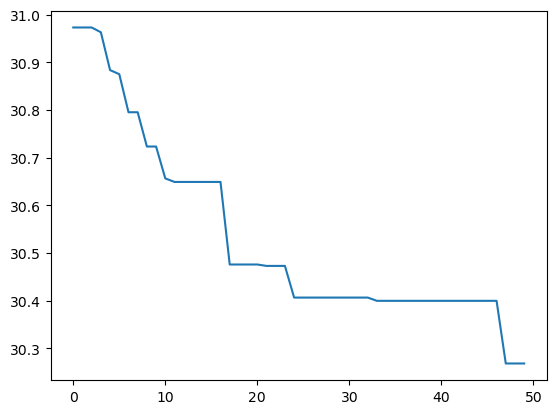

In [58]:

ruta_json = r'C:\Users\valen\OneDrive\Escritorio\-\UNIVERSIDAD\UCLM\3º\1er Cuatri\Sistemas Inteligentes\Prácticas\practicas_Inteligengtes\pr2_SSII\sample-problems-lab2\medium\calle_agustina_aroca_albacete_500_1_candidates_89_ns_22.json'
problema = Problema(ruta_json)

valores = BusquedaGenetica(problema, 100, 50).buscar()

plt.plot(valores)
plt.show()

Mejor solucion: [[(10773120419, 18720), (1526105997, 13127), (618009048, 17650), (1572435249, 8089), (1528181122, 11504), (335720320, 11962), (1527972839, 13892), (1529197036, 4836), (335607957, 14485), (1529197029, 1401), (1293940882, 1002), (1574598070, 12616), (1538396680, 2980), (1528822986, 4766), (1255528495, 13380), (2736548945, 16138), (1554807113, 12353), (1255528474, 3840), (1560897796, 1828), (1528181112, 16295), (1526105992, 14933), (335893167, 1540)], 30.7222081237951]


ValueError: x, y, and format string must not be None

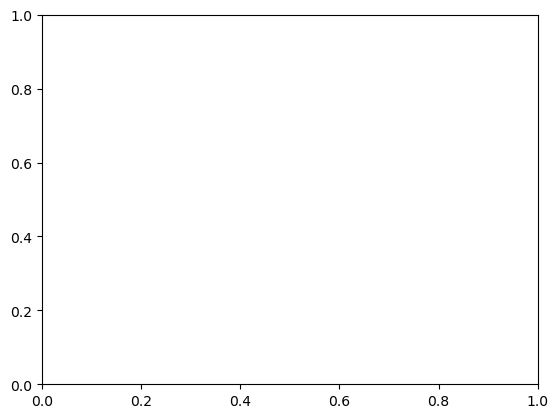

In [57]:
ruta_json = r'C:\Users\valen\OneDrive\Escritorio\-\UNIVERSIDAD\UCLM\3º\1er Cuatri\Sistemas Inteligentes\Prácticas\practicas_Inteligengtes\pr2_SSII\sample-problems-lab2\medium\calle_agustina_aroca_albacete_500_1_candidates_89_ns_22.json'
problema = Problema(ruta_json)

valores = BusquedaAleatoria(problema, 100).buscar()
